#### Import Package Dependencies

In [1]:
import os, sys, re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

from datetime import date
import warnings
warnings.filterwarnings('ignore')
# display options
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

#### Import Dataset

In [2]:
df = pd.read_csv('dataset_olist_merged.csv')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_state,geolocation_city,customer_geolocation_lat,customer_geolocation_lng,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio be...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,SP,sao paulo,-23.576983,-46.587161,9350,maua,SP,-23.680729,-46.444238,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,BA,barreiras,-12.177924,-44.660711,31570,belo horizonte,SP,-19.807681,-43.980427,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,GO,vianopolis,-16.745150,-48.514783,14840,guariba,SP,-21.363502,-48.229601,auto


#### Data Pre-processing

In [3]:
# Euclidean distances between seller and customer
df['euclidean_distance'] = (np.sqrt(((df['customer_geolocation_lat'] - df['seller_geolocation_lat']) ** 2) +
                                          ((df['customer_geolocation_lng'] - df['seller_geolocation_lng']) ** 2)))

In [4]:
lst_datetime = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_answer_timestamp','shipping_limit_date']

for timestamp in lst_datetime:
    df[timestamp] = pd.to_datetime(df[timestamp])

df['approving_time'] = df[['order_purchase_timestamp','order_approved_at']].apply(
    lambda row : str(row['order_approved_at'] - row['order_purchase_timestamp']).split(' ')[0], axis=1
)
df['processing_time'] = df[['order_approved_at','order_delivered_carrier_date']].apply(
    lambda row : str(row['order_delivered_carrier_date'] - row['order_approved_at']).split(' ')[0], axis=1
)
df['delivery_time'] = df[['order_delivered_carrier_date','order_delivered_customer_date']].apply(
    lambda row : str(row['order_delivered_customer_date'] - row['order_delivered_carrier_date']).split(' ')[0], axis=1
)
df['delivered_on_time'] = df[['order_delivered_customer_date','order_estimated_delivery_date']].apply(
    lambda row : 1 if row['order_delivered_customer_date'] <= row['order_estimated_delivery_date'] else 0, axis=1
)

df['delivered_late'] = df[['order_delivered_customer_date','order_estimated_delivery_date']].apply(
    lambda row : 0 if row['order_delivered_customer_date'] <= row['order_estimated_delivery_date'] else 1, axis=1
)

df['seller_on_time'] = df[['order_delivered_carrier_date','shipping_limit_date']].apply(
    lambda row : 1 if row['order_delivered_carrier_date'] <= row['shipping_limit_date'] else 0, axis=1
)

df['order_completion_time'] = df[['order_delivered_customer_date','order_purchase_timestamp']].apply(
    lambda row : str(row['order_delivered_customer_date'] - row['order_purchase_timestamp']).split(' ')[0], axis=1
)

df['approving_time'] = df['approving_time'].astype(str).replace('NaT', '0')
df['processing_time'] = df['processing_time'].astype(str).replace('NaT', '0')
df['delivery_time'] = df['delivery_time'].astype(str).replace('NaT', '0')
df['order_completion_time'] = df['order_completion_time'].astype(str).replace('NaT', '0')

In [5]:
df['payment_value'] = df['payment_value'].fillna(df['payment_value'].mean()).astype(int)
df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date       1268
order_delivered_customer_date      2629
order_estimated_delivery_date         0
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         0
review_id                          1016
review_score                       1016
review_comment_title             108316
review_comment_message            71343
review_creation_date               1016
review_answer_timestamp            1016
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0


#### Identify Regression Tasks & Response Variable:

__Some common regression task ideas:__


| Target Variable  | Description |
| ------------- | ------------- |
| order_completion_time  | Predict how many days a delivery takes (from customer purchase to delivered) |
| price/freight value  | Predict product pricing or shipping cost |
| payment_value         | Predict the total payment per order --> identify who are the high-valued customer |

In [6]:
df.groupby(by=['order_id'], as_index=False).agg(
    payment_value = ('payment_value','sum')
)['payment_value'].describe()

count     96774.000000
mean        219.621283
std         661.868878
min           9.000000
25%          64.000000
50%         114.000000
75%         208.000000
max      109312.000000
Name: payment_value, dtype: float64

In [7]:
df['order_id'].nunique()

96774

#### Train-test Split

In [13]:
#### Train-test split
from sklearn.model_selection import train_test_split

# work with indexes
index_train, index_test = train_test_split(df.index, train_size = 0.7, random_state = 42)

# write training and test sets
# copy() does not make a difference here but it's better to be explicit
df_train = df.loc[index_train, :].copy()
df_test = df.loc[index_test, :].copy()

print("------------------------------------------------------------------------------------------------------------------------")
print("Variables in the training set:")
print(df_train.columns.to_list())
print("------------------------------------------------------------------------------------------------------------------------")
print("Variables in the test set:")
print(df_test.columns.to_list())

------------------------------------------------------------------------------------------------------------------------
Variables in the training set:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'geolocation_state', 'geolocation_city', 'customer_geolocation_lat', 'customer_geolocati

#### Data Type Detection

In [9]:
from dabl import detect_types # useful for data exploration, from tutorial
detected = detect_types(df_train)

useless_features = detected[detected['useless'] == True].index.to_list()
lst_continuous = detected[detected['continuous'] == True].index.to_list()
lst_float = detected[detected['dirty_float'] == True].index.to_list()
lst_ordinal = detected[detected['low_card_int_ordinal'] == True].index.to_list()
lst_categorical = detected[detected['categorical'] == True].index.to_list()
lst_datetime = detected[detected['date'] == True].index.to_list()
lst_string = detected[detected['free_string'] == True].index.to_list()

print("----------------------------------------------------------------------------------------------------------------------------")
print("Continuous variables:\n",lst_continuous)
print("\nDirty Float variables:\n", lst_float)
print("\nOrdinal variables:\n", lst_ordinal)
print("\nCategorical variables:\n", lst_categorical)
print("\nDatetime variables:\n", lst_datetime)
print("\nString variables:\n", lst_string)

----------------------------------------------------------------------------------------------------------------------------
Continuous variables:
 ['payment_installments', 'payment_value', 'review_score', 'customer_zip_code_prefix', 'price', 'freight_value', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_geolocation_lat', 'customer_geolocation_lng', 'seller_zip_code_prefix', 'seller_geolocation_lat', 'seller_geolocation_lng', 'euclidean_distance']

Dirty Float variables:
 []

Ordinal variables:
 ['product_name_lenght', 'product_photos_qty', 'approving_time', 'processing_time', 'delivery_time', 'order_completion_time']

Categorical variables:
 ['payment_type', 'customer_state', 'product_category_name', 'geolocation_state', 'seller_city', 'seller_state', 'product_category_name_english', 'delivered_on_time', 'delivered_late', 'seller_on_time']

Datetime variables:
 ['order_purchase_timestamp', 'order_approved_at',

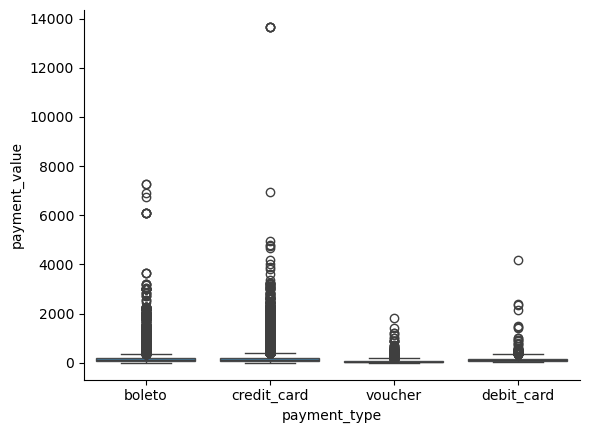

In [10]:
sns.boxplot(x = df_train['payment_type'], y = df_train['payment_value'], boxprops=dict(alpha=.9))
sns.despine()
plt.show()

In [11]:
def plotregressions(X, y, lowess=False):
    # X should be a pandas dataframe
    
    colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    # Feature names
    labels = list(X.columns)
    
    n, p = X.shape
    
    # We want three plots per column, calculate the required number of rows accordingly
    rows = int(np.ceil(p/3)) 
    
    # Create a plot grid
    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))

    # Loop over the plot grid, create 
    for i, ax in enumerate(fig.axes):
        if i < p:
            
            # Scatter plot with local smoothing
            sns.regplot(x = X.iloc[:, i], y=y,  ci=None, y_jitter=0.05, 
                        scatter_kws={'s': 25, 'alpha':.8}, ax=ax, lowess=lowess, color=colours[i % 10])
            
            # Remove axis labels to de-clutter the plot
            ax.set_xlabel('')
            ax.set_ylabel('')
            
            # Manually set the limits for the horizontal axis since the default doesn't work so well
            xmin = X.iloc[:,i].min()
            xmax = X.iloc[:,i].max()
            ax.set_xlim(xmin - (xmax-xmin)*0.05, xmax + (xmax - xmin)*0.05)
            
            # Use the feature name for the title
            ax.set_title(labels[i])
        
        else:
            # Delete unnecessary subplots (last row)
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

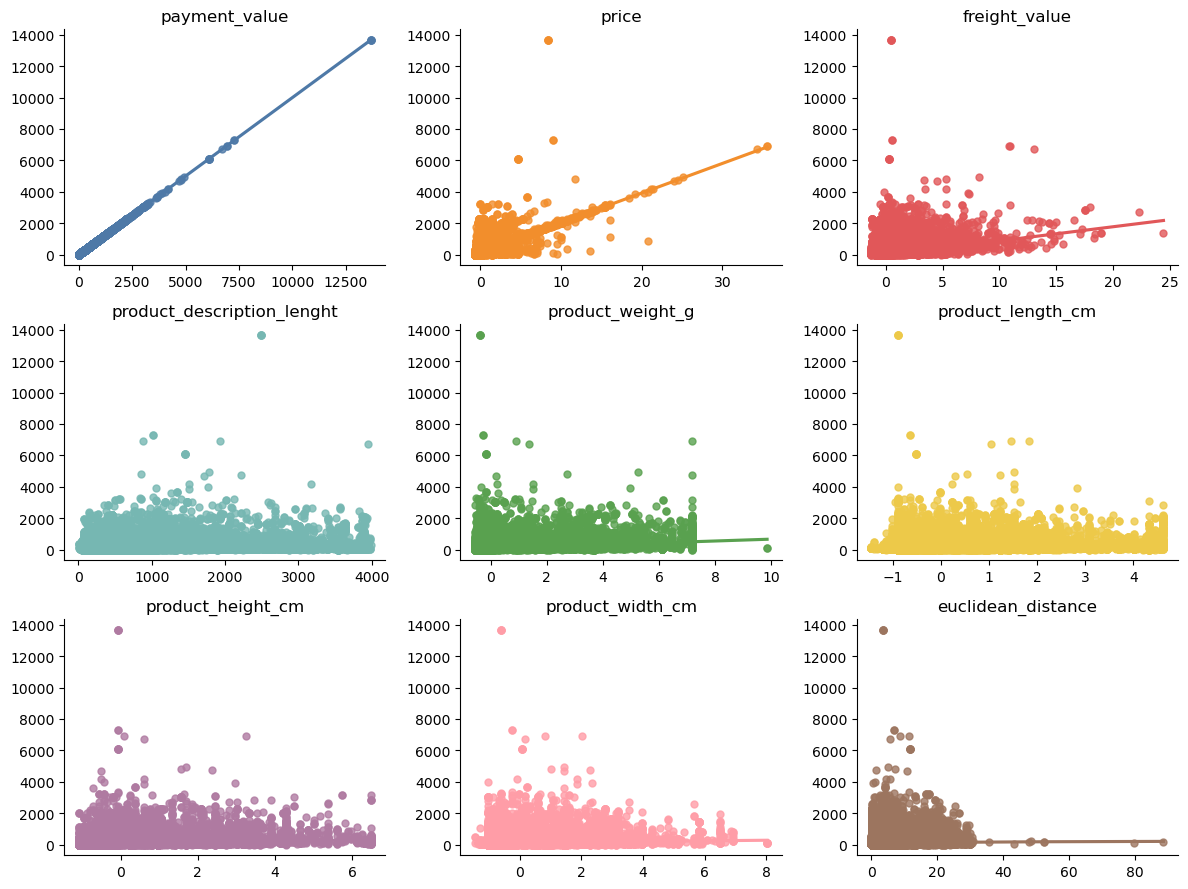

In [42]:
y_train = train['payment_value'].to_numpy()

plotregressions(train[lst_numerical], y_train, lowess=True)
plt.show()

#### EDA: Encoding Categorical Features

In [14]:
#### encode the top 10 most popular product category and categorize the rest as 'Otherss'
def product_category(x):
    if x == 'bed_bath_table':
        return 'Bed_bath_table'
    elif x == 'health_beauty':
        return 'Health_beauty'
    elif x == 'sports_leisure':
        return 'Sports_leisure'
    elif x == 'furniture_decor':
        return 'Furniture_decor'
    elif x == 'computers_accessories':
        return 'Computer_accessories'
    elif x == 'housewares':
        return 'Houseware'
    elif x == 'watches_gifts':
        return 'Watches_gifts'
    elif x == 'telephony':
        return 'Telephony'
    elif x == 'auto':
        return 'Auto'
    elif x == 'garden_tools':
        return 'Garden_tools'
    else:
        return 'Others'


df_train['product_category_name_english'] = df_train['product_category_name_english'].apply(product_category)
df_test['product_category_name_english'] = df_test['product_category_name_english'].apply(product_category)

In [15]:
### Convert _geolocation_state_ Field
def geolocation_converter(x):
    if x == 'SP':
        return 1
    else:
        return 0

df_train['geolocation_state'] = df_train['geolocation_state'].apply(geolocation_converter)
df_test['geolocation_state'] = df_test['geolocation_state'].apply(geolocation_converter)

### Convert customer and seller location: if customer and seller are in the same state, encode as 1, otherwise 0
df_train['customer_seller_loc'] = df_train[['customer_state','seller_state']].apply(
    lambda row: 0 if row['customer_state'] != row['seller_state'] else 1, axis = 1
)
df_test['customer_seller_loc'] = df_test[['customer_state','seller_state']].apply(
    lambda row: 0 if row['customer_state'] != row['seller_state'] else 1, axis = 1
)

#### Select feature list for regression model prediction 

In [20]:
lst_numerical = ['payment_value','price','freight_value','product_description_lenght',
                 'product_weight_g','product_length_cm','product_height_cm','product_width_cm','euclidean_distance']
lst_categorical = ['payment_type','product_category_name_english','geolocation_state','customer_seller_loc']
lst_time = ['approving_time', 'processing_time', 'delivery_time', 'delivered_on_time', 
            'delivered_late', 'seller_on_time', 'order_completion_time']

lst_identifier = ['order_id','customer_id']

feature_list = lst_numerical + lst_categorical + lst_time + lst_identifier

train = df_train[feature_list].copy()
test = df_test[feature_list].copy()

print("******Check train and test set shape:*******")
print(train.shape)
print(test.shape)

******Check train and test set shape:*******
(86105, 22)
(36903, 22)


In [21]:
train

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,product_category_name_english,geolocation_state,customer_seller_loc,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,order_completion_time,order_id,customer_id
92000,241,219.90,22.03,268.0,2700.0,41.0,8.0,36.0,7.806914,boleto,Bed_bath_table,0,0,0,2,21,1,0,1,25,057712e71c25f78b04ba3452284c110b,193754de85c4fb8fa230a4da9b125c66
112671,116,42.95,15.10,412.0,400.0,17.0,7.0,12.0,8.048100,credit_card,Others,0,0,0,0,10,1,0,1,10,6a5c14e6b9a898873a371e04d2e8f4d2,1c587d7f2e6a80b508b880020d1ad07d
66272,95,79.90,15.32,2375.0,1400.0,30.0,20.0,26.0,4.305249,credit_card,Bed_bath_table,0,0,0,15,6,1,0,0,21,efee98b139c9167c141b4892eecb215b,8207d1e4a52163b3351a281e7f553fa4
81973,134,110.00,24.90,718.0,400.0,30.0,5.0,30.0,12.490754,credit_card,Others,1,0,0,3,14,1,0,1,17,0f1657174bf9b83165da972c16b656f5,7178f347b7b8ef2035bcdd1f53748466
95088,83,70.00,13.15,2026.0,100.0,11.0,11.0,11.0,2.631781,boleto,Health_beauty,1,1,0,25,7,0,1,0,33,885ae5d5896b9a5f3bd2a626876ace12,b9c89128e72b43ac939802d32ad5c1cf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,95,35.99,11.85,942.0,575.0,26.0,15.0,18.0,4.149282,credit_card,Others,1,1,2,1,4,1,0,1,7,9b8d8bda9cab2bc51a14d444adc6af8a,28c99f67a6c4f18ab59f86f83dd36b55
103694,236,199.90,36.91,2261.0,16500.0,58.0,28.0,58.0,1.324689,credit_card,Others,1,1,1,4,5,1,0,1,12,8d6ed3e982e12a1684b31540309e044b,129468ef8647b08efc12e04af8506cfc
860,98,82.00,16.82,965.0,850.0,16.0,32.0,16.0,3.501271,credit_card,Others,0,0,0,0,9,1,0,1,9,2d9ea2efa410b1efd6bbd47d126819b6,3a3fc10a053a684ea7b581c82916e794
15795,83,62.80,20.89,1626.0,175.0,17.0,10.0,19.0,13.655855,credit_card,Others,0,0,1,0,14,1,0,1,16,1e6e729cbdd94df526b317598aaaaf62,9452bc0fd2c071a21ea6fd2373fe0c23


In [22]:
### drop anomaly observations to avoid confusion in modeling process
# print(train[train['payment_type'].isnull()])
# print(test[test['payment_type'].isnull()])

train.drop([38113, 38114], inplace=True)
test.drop([38115], inplace=True)

In [23]:
train['approving_time'] = train['approving_time'].astype(int)
train['processing_time'] = train['processing_time'].astype(int)
train['delivery_time'] = train['delivery_time'].astype(int)
train['order_completion_time'] = train['order_completion_time'].astype(int)

test['approving_time'] = test['approving_time'].astype(int)
test['processing_time'] = test['processing_time'].astype(int)
test['delivery_time'] = test['delivery_time'].astype(int)
test['order_completion_time'] = test['order_completion_time'].astype(int)

train.dtypes

payment_value                      int64
price                            float64
freight_value                    float64
product_description_lenght       float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
euclidean_distance               float64
payment_type                      object
product_category_name_english     object
geolocation_state                  int64
customer_seller_loc                int64
approving_time                     int64
processing_time                    int64
delivery_time                      int64
delivered_on_time                  int64
delivered_late                     int64
seller_on_time                     int64
order_completion_time              int64
order_id                          object
customer_id                       object
dtype: object

##### Feature Engineering

			

| Scaler | Handles Outliers? | Preserves Distribution? | Ideal For|
|--------|------------------------|-------------|-------------|
|StandardScaler |	❌ No	|✔️ Normal data |SVM, Logistic Regression |
|MinMaxScaler |	❌ No	|❌ Can distort |	Neural nets (0–1 input)|
|RobustScaler |	✔️ Yes	|❌ No	| Linear models with outliers|
| PowerTransformer | ❌ No	| ✔️ Makes more normal| Skewed data, PCA|



##### One-hot Encoding to `product_category_name_english`

In [24]:
train = pd.get_dummies(train, columns = ['product_category_name_english'], drop_first=True, dtype=float)
train

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,geolocation_state,customer_seller_loc,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,order_completion_time,order_id,customer_id,product_category_name_english_Bed_bath_table,product_category_name_english_Computer_accessories,product_category_name_english_Furniture_decor,product_category_name_english_Garden_tools,product_category_name_english_Health_beauty,product_category_name_english_Houseware,product_category_name_english_Others,product_category_name_english_Sports_leisure,product_category_name_english_Telephony,product_category_name_english_Watches_gifts
92000,241,219.90,22.03,268.0,2700.0,41.0,8.0,36.0,7.806914,boleto,0,0,0,2,21,1,0,1,25,057712e71c25f78b04ba3452284c110b,193754de85c4fb8fa230a4da9b125c66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112671,116,42.95,15.10,412.0,400.0,17.0,7.0,12.0,8.048100,credit_card,0,0,0,0,10,1,0,1,10,6a5c14e6b9a898873a371e04d2e8f4d2,1c587d7f2e6a80b508b880020d1ad07d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66272,95,79.90,15.32,2375.0,1400.0,30.0,20.0,26.0,4.305249,credit_card,0,0,0,15,6,1,0,0,21,efee98b139c9167c141b4892eecb215b,8207d1e4a52163b3351a281e7f553fa4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81973,134,110.00,24.90,718.0,400.0,30.0,5.0,30.0,12.490754,credit_card,1,0,0,3,14,1,0,1,17,0f1657174bf9b83165da972c16b656f5,7178f347b7b8ef2035bcdd1f53748466,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
95088,83,70.00,13.15,2026.0,100.0,11.0,11.0,11.0,2.631781,boleto,1,1,0,25,7,0,1,0,33,885ae5d5896b9a5f3bd2a626876ace12,b9c89128e72b43ac939802d32ad5c1cf,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,95,35.99,11.85,942.0,575.0,26.0,15.0,18.0,4.149282,credit_card,1,1,2,1,4,1,0,1,7,9b8d8bda9cab2bc51a14d444adc6af8a,28c99f67a6c4f18ab59f86f83dd36b55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
103694,236,199.90,36.91,2261.0,16500.0,58.0,28.0,58.0,1.324689,credit_card,1,1,1,4,5,1,0,1,12,8d6ed3e982e12a1684b31540309e044b,129468ef8647b08efc12e04af8506cfc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,98,82.00,16.82,965.0,850.0,16.0,32.0,16.0,3.501271,credit_card,0,0,0,0,9,1,0,1,9,2d9ea2efa410b1efd6bbd47d126819b6,3a3fc10a053a684ea7b581c82916e794,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15795,83,62.80,20.89,1626.0,175.0,17.0,10.0,19.0,13.655855,credit_card,0,0,1,0,14,1,0,1,16,1e6e729cbdd94df526b317598aaaaf62,9452bc0fd2c071a21ea6fd2373fe0c23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
test = pd.get_dummies(test, columns = ['product_category_name_english'], drop_first=True, dtype=float)
test

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,geolocation_state,customer_seller_loc,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,order_completion_time,order_id,customer_id,product_category_name_english_Bed_bath_table,product_category_name_english_Computer_accessories,product_category_name_english_Furniture_decor,product_category_name_english_Garden_tools,product_category_name_english_Health_beauty,product_category_name_english_Houseware,product_category_name_english_Others,product_category_name_english_Sports_leisure,product_category_name_english_Telephony,product_category_name_english_Watches_gifts
46423,110,87.00,23.33,732.0,225.0,16.0,13.0,11.0,14.933788,debit_card,0,0,1,-2,6,1,0,1,7,f85a3babb8f57542a4493f9c45523501,2abea2bf3e5611f7a96f8d24f21a7198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4545,406,385.00,21.23,796.0,450.0,30.0,13.0,23.0,9.882001,boleto,0,0,1,0,29,0,1,1,31,0904fb2c91a18099a0b7315f1ac9501b,d3d5a2955341122b1b68164dcbbc948e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5210,57,39.00,18.44,718.0,150.0,16.0,8.0,16.0,3.143285,voucher,0,0,0,-1,6,1,0,1,6,4e157a36ea9cf89bde6fff57a780b525,24970f1325070d89a1c42dd450b09a8a,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68255,356,150.00,16.02,616.0,4000.0,30.0,35.0,30.0,7.934835,credit_card,0,0,0,4,7,0,1,0,11,51d70226d271148b34f0ae2a6aaef7e8,4cf578782ee091c527c27a22b558a5ba,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10118,26,18.99,7.78,365.0,50.0,19.0,3.0,11.0,0.181673,credit_card,1,1,0,7,0,1,0,0,7,72a200617f45c76ab4e2c202a681958f,dc395448cf404b7c1c9782e475b1aeef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95755,88,70.97,17.75,673.0,3008.0,32.0,45.0,32.0,4.537446,credit_card,0,0,0,6,0,0,1,0,0,7a6351ddca16a16c5ec71c79dfef9374,cec91dd67b9dcd548f311238e3c1c76c,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63521,111,94.90,16.63,1700.0,750.0,59.0,14.0,12.0,3.740634,credit_card,0,0,0,3,14,1,0,1,17,d1d6de6c479c3d44a5371f79d677fe52,503ffd7cfd94e2c0c94bb44713dd44b8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51394,60,14.90,15.23,675.0,167.0,16.0,4.0,11.0,3.349398,credit_card,0,0,0,0,5,1,0,1,5,21fbb7ffe47d9cc3a504f6ac4ee24c9a,4875ee0c667adc19c074d48b862bae0d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
122075,87,68.90,18.28,659.0,1038.0,41.0,22.0,28.0,4.449427,credit_card,0,0,0,0,2,1,0,1,3,a524add4c939052769dca61e4e2cebb0,4f0c2a0d40df22bbf75a773c7ea9344d,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### Apply ordinal encoding to categorical columns



In [26]:
from sklearn.preprocessing import OrdinalEncoder

# 1. Define the columns to encode
cols_to_ord_encode = ['payment_type']

# 2. Initialize the encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# 3. Fit on training data
encoder.fit(df_train[cols_to_ord_encode])

# 4. Transform both train and test sets
train[cols_to_ord_encode] = encoder.transform(train[cols_to_ord_encode])
test[cols_to_ord_encode] = encoder.transform(test[cols_to_ord_encode])

train

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,geolocation_state,customer_seller_loc,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,order_completion_time,order_id,customer_id,product_category_name_english_Bed_bath_table,product_category_name_english_Computer_accessories,product_category_name_english_Furniture_decor,product_category_name_english_Garden_tools,product_category_name_english_Health_beauty,product_category_name_english_Houseware,product_category_name_english_Others,product_category_name_english_Sports_leisure,product_category_name_english_Telephony,product_category_name_english_Watches_gifts
92000,241,219.90,22.03,268.0,2700.0,41.0,8.0,36.0,7.806914,0.0,0,0,0,2,21,1,0,1,25,057712e71c25f78b04ba3452284c110b,193754de85c4fb8fa230a4da9b125c66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112671,116,42.95,15.10,412.0,400.0,17.0,7.0,12.0,8.048100,1.0,0,0,0,0,10,1,0,1,10,6a5c14e6b9a898873a371e04d2e8f4d2,1c587d7f2e6a80b508b880020d1ad07d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66272,95,79.90,15.32,2375.0,1400.0,30.0,20.0,26.0,4.305249,1.0,0,0,0,15,6,1,0,0,21,efee98b139c9167c141b4892eecb215b,8207d1e4a52163b3351a281e7f553fa4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81973,134,110.00,24.90,718.0,400.0,30.0,5.0,30.0,12.490754,1.0,1,0,0,3,14,1,0,1,17,0f1657174bf9b83165da972c16b656f5,7178f347b7b8ef2035bcdd1f53748466,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
95088,83,70.00,13.15,2026.0,100.0,11.0,11.0,11.0,2.631781,0.0,1,1,0,25,7,0,1,0,33,885ae5d5896b9a5f3bd2a626876ace12,b9c89128e72b43ac939802d32ad5c1cf,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,95,35.99,11.85,942.0,575.0,26.0,15.0,18.0,4.149282,1.0,1,1,2,1,4,1,0,1,7,9b8d8bda9cab2bc51a14d444adc6af8a,28c99f67a6c4f18ab59f86f83dd36b55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
103694,236,199.90,36.91,2261.0,16500.0,58.0,28.0,58.0,1.324689,1.0,1,1,1,4,5,1,0,1,12,8d6ed3e982e12a1684b31540309e044b,129468ef8647b08efc12e04af8506cfc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,98,82.00,16.82,965.0,850.0,16.0,32.0,16.0,3.501271,1.0,0,0,0,0,9,1,0,1,9,2d9ea2efa410b1efd6bbd47d126819b6,3a3fc10a053a684ea7b581c82916e794,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15795,83,62.80,20.89,1626.0,175.0,17.0,10.0,19.0,13.655855,1.0,0,0,1,0,14,1,0,1,16,1e6e729cbdd94df526b317598aaaaf62,9452bc0fd2c071a21ea6fd2373fe0c23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
test

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,geolocation_state,customer_seller_loc,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,order_completion_time,order_id,customer_id,product_category_name_english_Bed_bath_table,product_category_name_english_Computer_accessories,product_category_name_english_Furniture_decor,product_category_name_english_Garden_tools,product_category_name_english_Health_beauty,product_category_name_english_Houseware,product_category_name_english_Others,product_category_name_english_Sports_leisure,product_category_name_english_Telephony,product_category_name_english_Watches_gifts
46423,110,87.00,23.33,732.0,225.0,16.0,13.0,11.0,14.933788,2.0,0,0,1,-2,6,1,0,1,7,f85a3babb8f57542a4493f9c45523501,2abea2bf3e5611f7a96f8d24f21a7198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4545,406,385.00,21.23,796.0,450.0,30.0,13.0,23.0,9.882001,0.0,0,0,1,0,29,0,1,1,31,0904fb2c91a18099a0b7315f1ac9501b,d3d5a2955341122b1b68164dcbbc948e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5210,57,39.00,18.44,718.0,150.0,16.0,8.0,16.0,3.143285,3.0,0,0,0,-1,6,1,0,1,6,4e157a36ea9cf89bde6fff57a780b525,24970f1325070d89a1c42dd450b09a8a,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68255,356,150.00,16.02,616.0,4000.0,30.0,35.0,30.0,7.934835,1.0,0,0,0,4,7,0,1,0,11,51d70226d271148b34f0ae2a6aaef7e8,4cf578782ee091c527c27a22b558a5ba,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10118,26,18.99,7.78,365.0,50.0,19.0,3.0,11.0,0.181673,1.0,1,1,0,7,0,1,0,0,7,72a200617f45c76ab4e2c202a681958f,dc395448cf404b7c1c9782e475b1aeef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95755,88,70.97,17.75,673.0,3008.0,32.0,45.0,32.0,4.537446,1.0,0,0,0,6,0,0,1,0,0,7a6351ddca16a16c5ec71c79dfef9374,cec91dd67b9dcd548f311238e3c1c76c,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63521,111,94.90,16.63,1700.0,750.0,59.0,14.0,12.0,3.740634,1.0,0,0,0,3,14,1,0,1,17,d1d6de6c479c3d44a5371f79d677fe52,503ffd7cfd94e2c0c94bb44713dd44b8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51394,60,14.90,15.23,675.0,167.0,16.0,4.0,11.0,3.349398,1.0,0,0,0,0,5,1,0,1,5,21fbb7ffe47d9cc3a504f6ac4ee24c9a,4875ee0c667adc19c074d48b862bae0d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
122075,87,68.90,18.28,659.0,1038.0,41.0,22.0,28.0,4.449427,1.0,0,0,0,0,2,1,0,1,3,a524add4c939052769dca61e4e2cebb0,4f0c2a0d40df22bbf75a773c7ea9344d,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### Apply the Standard Scaler Transformation:

In preventing data leakage:
Always apply the standard scaler separately to training and test set.
1. Fit the standard scaler only to the training set
2. Transform the test set using the same scaler
    * use the already-fit scaler to __transform__ the test set
    * do not refit it

* Fitting on training data ensures your model generalizes to unseen data.
* Fitting on the whole dataset before splitting gives overly optimistic performance estimates (data leakage).



In [29]:
train.columns.to_list()

['payment_value',
 'price',
 'freight_value',
 'product_description_lenght',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'euclidean_distance',
 'payment_type',
 'geolocation_state',
 'customer_seller_loc',
 'approving_time',
 'processing_time',
 'delivery_time',
 'delivered_on_time',
 'delivered_late',
 'seller_on_time',
 'order_completion_time',
 'order_id',
 'customer_id',
 'product_category_name_english_Bed_bath_table',
 'product_category_name_english_Computer_accessories',
 'product_category_name_english_Furniture_decor',
 'product_category_name_english_Garden_tools',
 'product_category_name_english_Health_beauty',
 'product_category_name_english_Houseware',
 'product_category_name_english_Others',
 'product_category_name_english_Sports_leisure',
 'product_category_name_english_Telephony',
 'product_category_name_english_Watches_gifts']

In [30]:
from sklearn.preprocessing import StandardScaler

# specify the columns to scale
cols_to_scale = ['price','freight_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm']

# Create StandardScaler object
scaler = StandardScaler()

# Fit and transform the scaler to the training set
train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])

# Tranform the testing set
test[cols_to_scale] = scaler.transform(test[cols_to_scale])

#### Save as csv file

In [40]:
train.to_csv('training_set_reg.csv', index=False)
test.to_csv('testing_set_reg.csv', index=False)

In [34]:
#### make log transformation to the price (target variable column) column
train['price_log'] = np.log1p(train['price'])
test['price_log'] = np.log1p(test['price'])

In [35]:
train

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,geolocation_state,customer_seller_loc,approving_time,processing_time,delivery_time,delivered_on_time,delivered_late,seller_on_time,order_completion_time,order_id,customer_id,product_category_name_english_Bed_bath_table,product_category_name_english_Computer_accessories,product_category_name_english_Furniture_decor,product_category_name_english_Garden_tools,product_category_name_english_Health_beauty,product_category_name_english_Houseware,product_category_name_english_Others,product_category_name_english_Sports_leisure,product_category_name_english_Telephony,product_category_name_english_Watches_gifts,price_log
92000,241,0.528475,0.117705,268.0,0.138228,0.663824,-0.644804,1.089971,7.806914,0.0,0,0,0,2,21,1,0,1,25,057712e71c25f78b04ba3452284c110b,193754de85c4fb8fa230a4da9b125c66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424271
112671,116,-0.422344,-0.316968,412.0,-0.454160,-0.820711,-0.718232,-0.941868,8.048100,1.0,0,0,0,0,10,1,0,1,10,6a5c14e6b9a898873a371e04d2e8f4d2,1c587d7f2e6a80b508b880020d1ad07d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.548777
66272,95,-0.223798,-0.303169,2375.0,-0.196600,-0.016588,0.236325,0.243371,4.305249,1.0,0,0,0,15,6,1,0,0,21,efee98b139c9167c141b4892eecb215b,8207d1e4a52163b3351a281e7f553fa4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.253342
81973,134,-0.062059,0.297720,718.0,-0.454160,-0.016588,-0.865086,0.582011,12.490754,1.0,1,0,0,3,14,1,0,1,17,0f1657174bf9b83165da972c16b656f5,7178f347b7b8ef2035bcdd1f53748466,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.064068
95088,83,-0.276994,-0.439279,2026.0,-0.531428,-1.191845,-0.424522,-1.026528,2.631781,0.0,1,1,0,25,7,0,1,0,33,885ae5d5896b9a5f3bd2a626876ace12,b9c89128e72b43ac939802d32ad5c1cf,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.324338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,95,-0.459743,-0.520819,942.0,-0.409087,-0.264011,-0.130812,-0.433908,4.149282,1.0,1,1,2,1,4,1,0,1,7,9b8d8bda9cab2bc51a14d444adc6af8a,28c99f67a6c4f18ab59f86f83dd36b55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.615710
103694,236,0.421008,1.051028,2261.0,3.692552,1.715369,0.823744,2.952489,1.324689,1.0,1,1,1,4,5,1,0,1,12,8d6ed3e982e12a1684b31540309e044b,129468ef8647b08efc12e04af8506cfc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.351366
860,98,-0.212514,-0.209084,965.0,-0.338258,-0.882567,1.117454,-0.603228,3.501271,1.0,0,0,0,0,9,1,0,1,9,2d9ea2efa410b1efd6bbd47d126819b6,3a3fc10a053a684ea7b581c82916e794,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.238909
15795,83,-0.315682,0.046200,1626.0,-0.512111,-0.820711,-0.497949,-0.349248,13.655855,1.0,0,0,1,0,14,1,0,1,16,1e6e729cbdd94df526b317598aaaaf62,9452bc0fd2c071a21ea6fd2373fe0c23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.379333


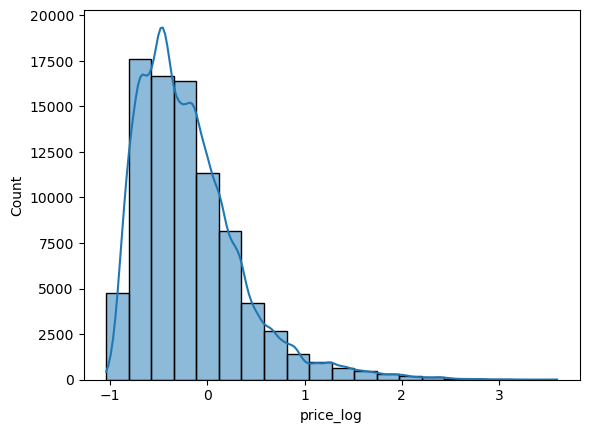

In [37]:
sns.histplot(train['price_log'], bins=20, kde=True)
plt.show()

In [39]:
# sns.histplot(train['price'], bins=20, kde=True)
# plt.show()